Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.7.3
IPython 7.6.1

tensorflow 1.13.1


# Model Zoo -- General Adversarial Networks

Implementation of General Adversarial Nets (GAN) where both the discriminator and generator are multi-layer perceptrons with one hidden layer only. In this example, the GAN generator was trained to generate MNIST images.

Uses

- samples from a random normal distribution (range [-1, 1])
- dropout
- leaky relus
- ~~batch normalization~~ [performs worse here]
- separate batches for "fake" and "real" images (where the labels are 1 = real images, 0 = fake images)
- MNIST images normalized to [-1, 1] range
- generator with tanh output


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pickle as pkl

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
### Abbreviatiuons
# dis_*: discriminator network
# gen_*: generator network

########################
### Helper functions
########################

def leaky_relu(x, alpha=0.0001):
    return tf.maximum(alpha * x, x)


########################
### DATASET
########################

mnist = input_data.read_data_sets('MNIST_data')


#########################
### SETTINGS
#########################

# Hyperparameters
learning_rate = 0.001
training_epochs = 100
batch_size = 64
dropout_rate = 0.5

# Other settings
print_interval = 200

# Architecture
dis_input_size = 784
gen_input_size = 100

dis_hidden_size = 128
gen_hidden_size = 128


#########################
### GRAPH DEFINITION
#########################

g = tf.Graph()
with g.as_default():
    
    # Placeholders for settings
    dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
    is_training = tf.placeholder(tf.bool, shape=None, name='is_training')
    
    # Input data
    dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size], name='discriminator_input') 
    gen_x = tf.placeholder(tf.float32, [None, gen_input_size], name='generator_input')


    ##################
    # Generator Model
    ##################

    with tf.variable_scope('generator'):
        # linear -> ~~batch norm~~ -> leaky relu -> dropout -> tanh output
        gen_hidden = tf.layers.dense(inputs=gen_x, units=gen_hidden_size,
                                      activation=None)
        #gen_hidden = tf.layers.batch_normalization(gen_hidden, training=is_training)
        gen_hidden = leaky_relu(gen_hidden)
        gen_hidden = tf.layers.dropout(gen_hidden, rate=dropout_rate)
        gen_logits = tf.layers.dense(inputs=gen_hidden, units=dis_input_size, 
                                     activation=None)
        gen_out = tf.tanh(gen_logits, 'generator_output')


    ######################
    # Discriminator Model
    ######################
    
    def build_discriminator_graph(input_x, reuse=None):
        # linear -> ~~batch norm~~ -> leaky relu -> dropout -> sigmoid output
        with tf.variable_scope('discriminator', reuse=reuse):
            hidden = tf.layers.dense(inputs=input_x, units=dis_hidden_size, 
                                     activation=None)
            #hidden = tf.layers.batch_normalization(hidden, training=is_training)
            hidden = leaky_relu(hidden)
            hidden = tf.layers.dropout(hidden, rate=dropout_rate)
            logits = tf.layers.dense(inputs=hidden, units=1, activation=None)
            out = tf.sigmoid(logits)
        return logits, out    

    # Create a discriminator for real data and a discriminator for fake data
    dis_real_logits, dis_real_out = build_discriminator_graph(dis_x, reuse=False)
    dis_fake_logits, dis_fake_out = build_discriminator_graph(gen_out, reuse=True)


    #####################################
    # Generator and Discriminator Losses
    #####################################
    
    # Two discriminator cost components: loss on real data + loss on fake data
    # Real data has class label 1, fake data has class label 0
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, 
                                                            labels=tf.ones_like(dis_real_logits))
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, 
                                                            labels=tf.zeros_like(dis_fake_logits))
    dis_cost = tf.add(tf.reduce_mean(dis_fake_loss), 
                      tf.reduce_mean(dis_real_loss), 
                      name='discriminator_cost')
 
    # Generator cost: difference between dis. prediction and label "1" for real images
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits,
                                                       labels=tf.ones_like(dis_fake_logits))
    gen_cost = tf.reduce_mean(gen_loss, name='generator_cost')
    
    
    #########################################
    # Generator and Discriminator Optimizers
    #########################################
      
    dis_optimizer = tf.train.AdamOptimizer(learning_rate)
    dis_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    dis_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    with tf.control_dependencies(dis_update_ops): # required to upd. batch_norm params
        dis_train = dis_optimizer.minimize(dis_cost, var_list=dis_train_vars,
                                           name='train_discriminator')
    
    gen_optimizer = tf.train.AdamOptimizer(learning_rate)
    gen_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops): # required to upd. batch_norm params
        gen_train = gen_optimizer.minimize(gen_cost, var_list=gen_train_vars,
                                           name='train_generator')
    
    # Saver to save session for reuse
    saver = tf.train.Saver()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


In [4]:
##########################
### TRAINING & EVALUATION
##########################

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_costs = {'discriminator': [], 'generator': []}

    for epoch in range(training_epochs):
        dis_avg_cost, gen_avg_cost = 0., 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x*2 - 1 # normalize
            batch_randsample = np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
            
            # Train
            _, dc = sess.run(['train_discriminator', 'discriminator_cost:0'],
                             feed_dict={'discriminator_input:0': batch_x, 
                                        'generator_input:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            _, gc = sess.run(['train_generator', 'generator_cost:0'],
                             feed_dict={'generator_input:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            dis_avg_cost += dc
            gen_avg_cost += gc

            if not i % print_interval:
                print("Minibatch: %03d | Dis/Gen Cost:    %.3f/%.3f" % (i + 1, dc, gc))
                

        print("Epoch:     %03d | Dis/Gen AvgCost: %.3f/%.3f" % 
              (epoch + 1, dis_avg_cost / total_batch, gen_avg_cost / total_batch))
        
        avg_costs['discriminator'].append(dis_avg_cost / total_batch)
        avg_costs['generator'].append(gen_avg_cost / total_batch)
    
    
    saver.save(sess, save_path='./gan.ckpt')

Minibatch: 001 | Dis/Gen Cost:    1.499/0.801
Minibatch: 201 | Dis/Gen Cost:    0.053/3.507
Minibatch: 401 | Dis/Gen Cost:    0.081/2.734
Minibatch: 601 | Dis/Gen Cost:    0.034/4.557
Minibatch: 801 | Dis/Gen Cost:    0.039/4.194
Epoch:     001 | Dis/Gen AvgCost: 0.118/3.638
Minibatch: 001 | Dis/Gen Cost:    0.057/5.300
Minibatch: 201 | Dis/Gen Cost:    0.116/3.594
Minibatch: 401 | Dis/Gen Cost:    0.280/5.187
Minibatch: 601 | Dis/Gen Cost:    0.194/3.634
Minibatch: 801 | Dis/Gen Cost:    0.173/5.460
Epoch:     002 | Dis/Gen AvgCost: 0.210/5.091
Minibatch: 001 | Dis/Gen Cost:    0.045/7.738
Minibatch: 201 | Dis/Gen Cost:    0.407/6.936
Minibatch: 401 | Dis/Gen Cost:    1.025/7.490
Minibatch: 601 | Dis/Gen Cost:    1.244/5.377
Minibatch: 801 | Dis/Gen Cost:    0.383/8.268
Epoch:     003 | Dis/Gen AvgCost: 0.425/6.283
Minibatch: 001 | Dis/Gen Cost:    0.303/4.227
Minibatch: 201 | Dis/Gen Cost:    0.920/6.391
Minibatch: 401 | Dis/Gen Cost:    0.439/5.984
Minibatch: 601 | Dis/Gen Cost:    

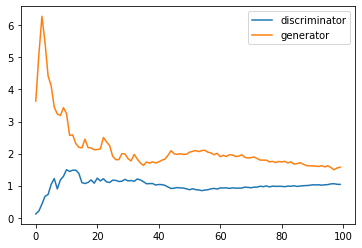

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(avg_costs['discriminator'])), 
         avg_costs['discriminator'], label='discriminator')
plt.plot(range(len(avg_costs['generator'])),
         avg_costs['generator'], label='generator')
plt.legend()
plt.show()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./gan.ckpt


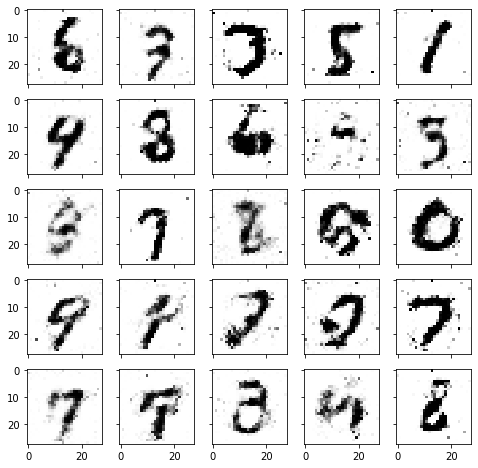

In [6]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./gan.ckpt')

    batch_randsample = np.random.uniform(-1, 1, size=(n_examples, gen_input_size))
    new_examples = sess.run('generator/generator_output:0',
                            feed_dict={'generator_input:0': batch_randsample,
                                       'dropout:0': 0.0,
                                       'is_training:0': False})

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                         sharey=True, sharex=True)

for image, ax in zip(new_examples, axes.flatten()):
    ax.imshow(image.reshape((dis_input_size // 28, dis_input_size // 28)), cmap='binary')

plt.show()